In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('4year.csv')

C:\Users\Oshan\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (0,1,2,5,6,7,9,10,13,14,15,16,17,21,23,24,25,28,33,34,35,37,47,49,50,56,58) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
columnList=df.columns

In [4]:
for item in columnList:
    df[item]=df[item].astype('str')
    df[item]=df[item].apply(lambda x: x.replace('?', '0')).astype('float')

In [5]:
from sklearn.feature_selection import f_classif

feature_cols = [col for col in df.columns if col != "class"]
X = df[feature_cols]
y = df["class"]

#fill missing values with zero
F, pval = f_classif(X.fillna(0), y)

pval_series = pd.Series(pval, index=X.columns)
pval_threshold = 0.01
top_features = pval_series[pval_series<pval_threshold].sort_values()
print(f"There are {len(top_features)} features with p-value less than {pval_threshold}: \n{top_features}")

There are 14 features with p-value less than 0.01: 
Attr1     3.606270e-13
Attr35    4.786015e-12
Attr29    1.171728e-09
Attr14    1.204875e-07
Attr7     1.208821e-07
Attr11    1.034981e-05
Attr22    1.700178e-05
Attr56    2.791602e-05
Attr39    2.930637e-05
Attr18    6.450455e-05
Attr12    1.083819e-04
Attr26    1.645456e-04
Attr16    1.966082e-04
Attr48    1.036412e-03
dtype: float64


<AxesSubplot:>

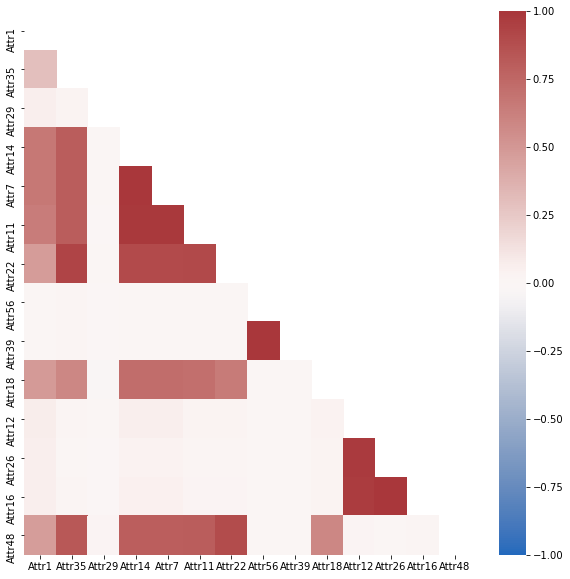

In [6]:
fig, ax = plt.subplots(figsize=(10,10))
corr_df = X[top_features.index].corr(method="pearson")
mask = np.triu(np.ones_like(corr_df, dtype=bool))
sns.heatmap(corr_df, cmap="vlag", vmin=-1, vmax=1, mask=mask, ax=ax)

In [7]:

target_frequency = df['class'].value_counts().rename("frequency")
target_proportion = df['class'].value_counts(normalize=True).rename("proportion")
pd.concat([target_frequency, target_proportion], axis=1)

,frequency,proportion
0.0,9277,0.947406
1.0,515,0.052594


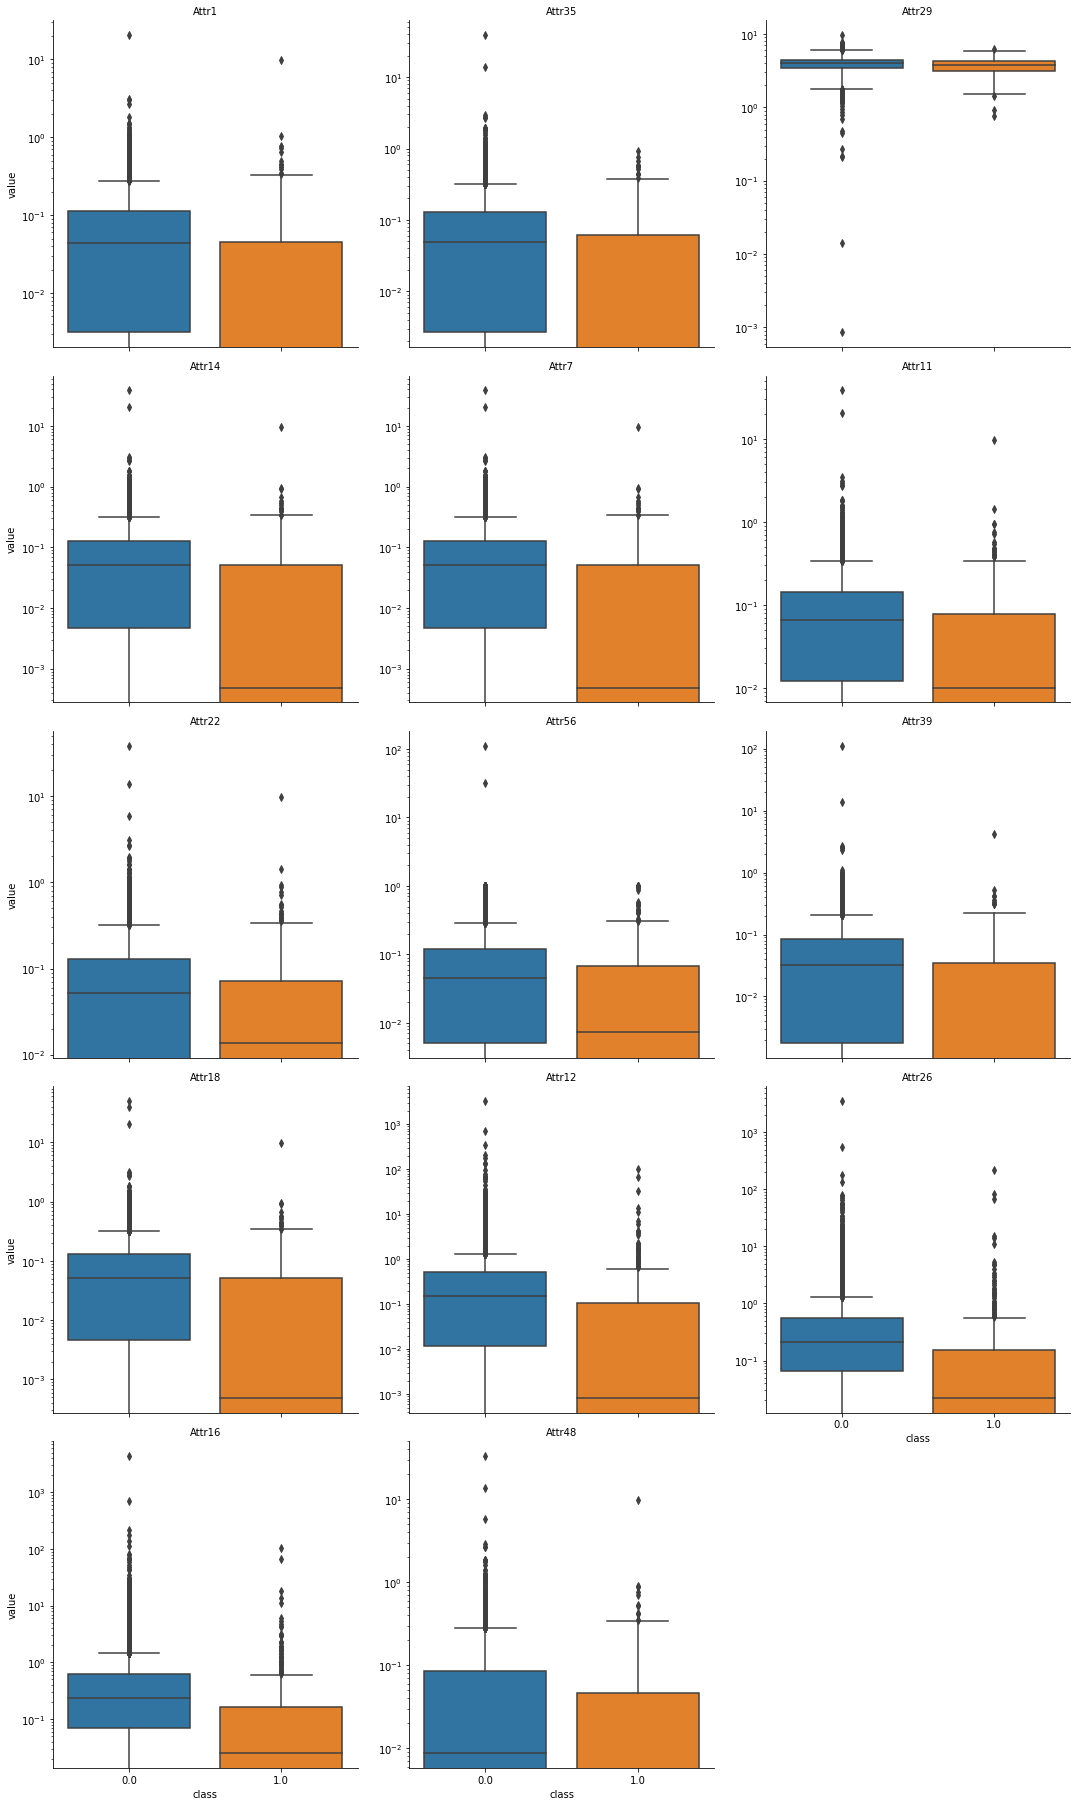

In [8]:
cols = top_features.index.to_list() + ["class"]
melted_df = df[cols].reset_index().melt(id_vars=["index","class"])

g = sns.catplot(data=melted_df, x="class", y="value", col="variable", kind="box", col_wrap=3, sharey=False)
g.set_titles(col_template="{col_name}")

# plot in logarithmic scale as there are a few companies with extremely large values 
for ax in g.axes.flatten():
    if ax.get_title() != "logarithm of total assets":
        ax.set_yscale('log')

In [9]:
for item in df:
    if item not in cols:
        del df[item]

In [10]:
from sklearn.model_selection import train_test_split

Y = df["class"]
X = df.drop(["class"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)

In [11]:
from sklearn.preprocessing import StandardScaler

In [12]:
X_scaler = StandardScaler().fit(X_train)

In [13]:
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [14]:
from sklearn.ensemble import RandomForestClassifier

In [15]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train_scaled,y_train)

RandomForestClassifier()

In [16]:
features_names = df.columns

In [17]:
sorted(zip(rf.feature_importances_, features_names), reverse=True) 

[(0.0921827712673717, 'Attr56'),
 (0.08549085947659987, 'Attr35'),
 (0.07778846745978456, 'Attr16'),
 (0.07265084157283741, 'Attr48'),
 (0.07252895218443071, 'Attr26'),
 (0.07191826953975705, 'Attr39'),
 (0.07073131962465595, 'Attr22'),
 (0.06930750524173852, 'Attr29'),
 (0.06875473777414175, 'Attr11'),
 (0.06687960322323255, 'Attr1'),
 (0.06674077763432128, 'Attr12'),
 (0.06299304615045692, 'Attr18'),
 (0.06253693129322768, 'Attr7'),
 (0.05949591755744414, 'Attr14')]

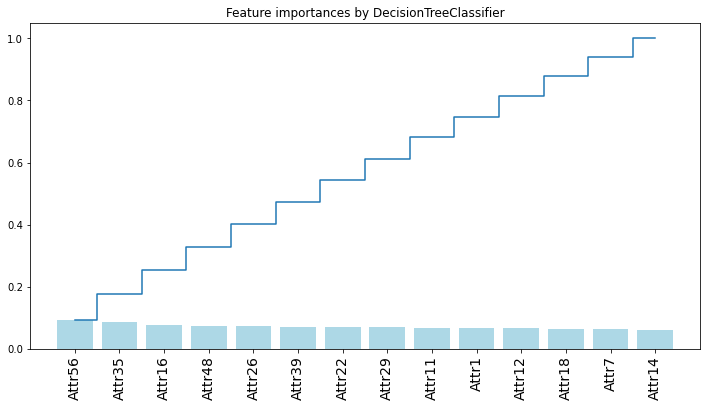

In [18]:
import matplotlib.pyplot as plt
importances = rf.feature_importances_


indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12,6))
plt.title("Feature importances by DecisionTreeClassifier")
plt.bar(range(len(indices)), importances[indices], color='lightblue',  align="center")
plt.step(range(len(indices)), np.cumsum(importances[indices]), where='mid', label='Cumulative')
plt.xticks(range(len(indices)), features_names[indices], rotation='vertical',fontsize=14)
plt.xlim([-1, len(indices)])
plt.show()

In [19]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report

In [20]:
#Make my predictions
y_prediction = rf.predict(X_test)
y_probability = rf.predict_proba(X_test)
y_probability[0][1]

0.24

In [21]:
print(classification_report(y_test, y_prediction,
                            target_names=["non_default", "default"]))

              precision    recall  f1-score   support

 non_default       0.95      1.00      0.97      2780
     default       0.20      0.01      0.01       158

    accuracy                           0.95      2938
   macro avg       0.57      0.50      0.49      2938
weighted avg       0.91      0.95      0.92      2938



In [22]:
score =rf.score(X_test_scaled, y_test)
print(score)

0.9428182437031994


In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

logreg = LogisticRegression()
logreg.fit(X_train_scaled, y_train)

LogisticRegression()

In [24]:
y_pred = logreg.predict(X_test_scaled)

In [26]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97      2780
         1.0       0.22      0.01      0.02       158

    accuracy                           0.94      2938
   macro avg       0.58      0.51      0.50      2938
weighted avg       0.91      0.94      0.92      2938



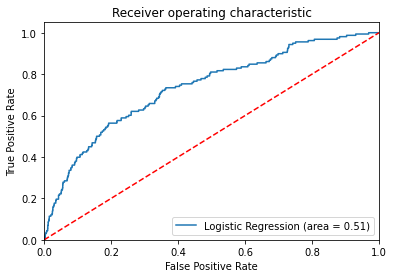

In [27]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test_scaled))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test_scaled)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()